## Confirm Py6S installation

In [10]:
from Py6S import *
SixS.test()


6S wrapper script by Robin Wilson
Using 6S located at /usr/local/bin/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

Running for many wavelengths - this may take a long time


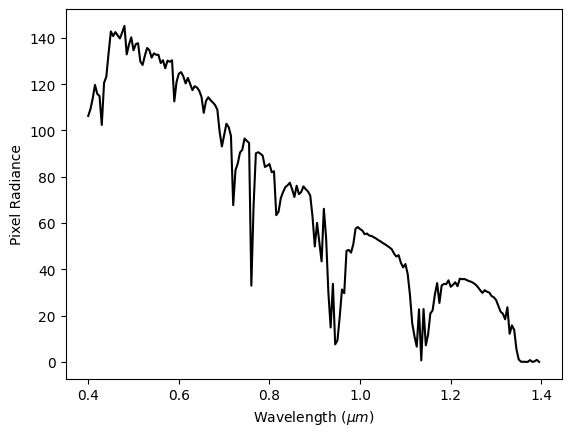

In [3]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

## Calculate maximum solar energy

In [1]:
import random
import logging
import pytz
import math
import requests
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Py6S import *
from io import StringIO
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder

In [11]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

#### Create 1x1 deg grid of all-sky DNI for swath of N. Atlantic for S23

In [ ]:
# Get estimated all-sky DNI from NASA POWER API for swath of N. Atlantic for Summer 2023 (1 deg x 1 deg)
def fetch_data(latitude, longitude): 
    url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?start=20220320&end=20220924&latitude={latitude}&longitude={longitude}&community=sb&parameters=ALLSKY_SFC_SW_DNI&format=csv&header=true&time-standard=utc"
    response = requests.get(url, headers={"accept": "application/json"})
    if response.status_code == 200:
        data = response.content.decode('utf-8')

        # Find the end of the header
        end_of_header = data.find("-END HEADER-") + len("-END HEADER-\n")
        data_no_header = data[end_of_header:]

        try:
            df = pd.read_csv(StringIO(data_no_header))
            return df
        except Exception as e:
            print(f"Error parsing data for latitude {latitude} and longitude {longitude}: {e}")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch data for latitude {latitude} and longitude {longitude}")
        return pd.DataFrame()


In [ ]:
all_data = pd.DataFrame()

for lon in range(-20, -51, -1):  # Step is -1 because we're moving from east to west
    for lat in range(61):
        df = fetch_data(lat, lon)
        if not df.empty:
            df['lat'] = lat  
            df['lon'] = lon 
            all_data = pd.concat([all_data, df], ignore_index=True)
    logging.info(f"Processed all latitudes for longitude {lon}")
    time.sleep(120)

# all_data.to_csv("/Users/timothydonohue/Downloads/nasa_power_data.csv", index=False)

In [2]:
df = pd.read_csv('/Users/timothydonohue/Documents/Data/nasa_power_data.csv')
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon
0,2022,3,20,0,0.0,0,-20
1,2022,3,20,1,0.0,0,-20
2,2022,3,20,2,0.0,0,-20
3,2022,3,20,3,0.0,0,-20
4,2022,3,20,4,0.0,0,-20


In [4]:
print(df.dtypes)
df.shape

YEAR                   int64
MO                     int64
DY                     int64
HR                     int64
ALLSKY_SFC_SW_DNI    float64
lat                    int64
lon                    int64
dtype: object


(8577576, 7)

In [5]:
df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}, inplace=True)
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['timestamp'] = df['timestamp'].apply(lambda x: int(time.mktime(x.timetuple())))

df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

# convert lat and lon columns to float
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

df.rename(columns={'ALLSKY_SFC_SW_DNI': 'sfc_dni'}, inplace=True)
df

,sfc_dni,lat,lon,timestamp
0,0.00,0.0,-20.0,1647748800
1,0.00,0.0,-20.0,1647752400
2,0.00,0.0,-20.0,1647756000
3,0.00,0.0,-20.0,1647759600
4,0.00,0.0,-20.0,1647763200
...,...,...,...,...
8577571,40.14,60.0,-50.0,1664060400
8577572,34.61,60.0,-50.0,1664064000
8577573,0.00,60.0,-50.0,1664067600
8577574,0.00,60.0,-50.0,1664071200


In [7]:
data_dict = {
    lat: {
        lon: group.set_index('timestamp')['sfc_dni'].apply(
            lambda x: {'sfc_dni': x, 'alt_adj_dni': float('nan')}
        ).to_dict()
        for lon, group in lat_group.groupby('lon')
    }
    for lat, lat_group in df.groupby('lat')
}

output_path = '/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl'
with open(output_path, 'wb') as pickle_file:
    pickle.dump(data_dict, pickle_file)

In [4]:
def print_dict_head(data_dict, num_entries=5):
    count = 0
    for lat, lon_dict in data_dict.items():
        for lon, timestamp_dict in lon_dict.items():
            for timestamp, values in timestamp_dict.items():
                print(f"Lat: {lat}, Lon: {lon}, Timestamp: {timestamp}, Values: {values}")
                count += 1
                if count >= num_entries:
                    return

# Example usage
print_dict_head(data_dict, 6)


Lat: 0.0, Lon: -50.0, Timestamp: 1647748800, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647752400, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647756000, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647759600, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647763200, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}
Lat: 0.0, Lon: -50.0, Timestamp: 1647766800, Values: {'sfc_dni': 0.0, 'alt_adj_dni': nan}


In [5]:
# Access the sfc_dni value
sfc_dni_value = data_dict[0][-50.0][1647752400]['sfc_dni']

# Print the value and its type
print(sfc_dni_value)
type(sfc_dni_value)


0.0
<class 'float'>


#### Built q-table and helper functions

In [3]:
with open('/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl', 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [6]:
def est_dni_from_py6s(latitude, longitude, altitude, dthz):
    s = SixS()
    dthz_30 = dthz + timedelta(minutes=30)
    logging.debug(f"Will use midpoint of hour (calculated as {dthz_30})")
    
    datetime_str = dthz_30.strftime('%Y-%m-%dT%H:%M:%S')
    s.atmos_profile = AtmosProfile.FromLatitudeAndDate(latitude, datetime_str)
    s.altitudes.set_target_custom_altitude(altitude / 1000)
    
    s.geometry = Geometry.User()
    s.geometry.from_time_and_location(latitude, longitude, datetime_str, 0, 0)
    
    if s.geometry.solar_z > 90:
        logging.debug(f"Sun is below the horizon at {latitude}, {longitude}, {altitude}m at {dthz_30}")
        return 0
    
    s.run()
    logging.debug(f"DHI at {latitude}, {longitude}, {altitude}m at {dthz_30} is "
                f"{s.outputs.direct_solar_irradiance:.1f} (solar_z: {s.outputs.solar_z})")
    
    dni = s.outputs.direct_solar_irradiance / math.cos(math.radians(s.outputs.solar_z))
    logging.debug(f"DNI at {latitude}, {longitude}, {altitude}m at {dthz_30} is {dni:.1f}")
    
    return dni


2024-03-13 11:20:21,072 - DEBUG - Will use midpoint of hour (calculated as 2023-03-20 00:30:00+00:00)
2024-03-13 11:20:21,074 - DEBUG - Sun is below the horizon at 42, -70, 0m at 2023-03-20 00:30:00+00:00
2024-03-13 11:20:21,076 - DEBUG - Will use midpoint of hour (calculated as 2023-03-20 01:30:00+00:00)
2024-03-13 11:20:21,078 - DEBUG - Sun is below the horizon at 42, -70, 0m at 2023-03-20 01:30:00+00:00
2024-03-13 11:20:21,079 - DEBUG - Will use midpoint of hour (calculated as 2023-03-20 02:30:00+00:00)
2024-03-13 11:20:21,081 - DEBUG - Sun is below the horizon at 42, -70, 0m at 2023-03-20 02:30:00+00:00
2024-03-13 11:20:21,083 - DEBUG - Will use midpoint of hour (calculated as 2023-03-20 03:30:00+00:00)
2024-03-13 11:20:21,084 - DEBUG - Sun is below the horizon at 42, -70, 0m at 2023-03-20 03:30:00+00:00
2024-03-13 11:20:21,086 - DEBUG - Will use midpoint of hour (calculated as 2023-03-20 04:30:00+00:00)
2024-03-13 11:20:21,087 - DEBUG - Sun is below the horizon at 42, -70, 0m at 2

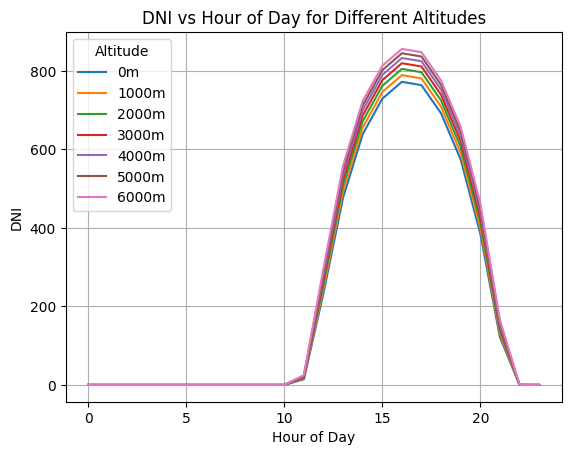

In [7]:
lat = 42
lon = -70
dtz = datetime(2023, 3, 20, 0, tzinfo=pytz.utc)

# Create a DataFrame to store irradiance data for all hours and altitudes
columns = ['Hour', 'Altitude', 'DNI']
rad_by_hour_and_alt = []

# Loop over altitudes from 0m to 6000m, in steps of 1000m
for alt in range(0, 7000, 1000):
    for hour in range(24):
        dthz = dtz + timedelta(hours=hour)
        irradiance = est_dni_from_py6s(lat, lon, alt, dthz)
        rad_by_hour_and_alt.append({'Hour': hour, 'Altitude': alt, 'DNI': irradiance})

df = pd.DataFrame(rad_by_hour_and_alt)
df.to_csv('/Users/timothydonohue/Downloads/solar_irradiance_ts.csv')

# Plotting
for altitude in range(0, 7000, 1000):
    subset = df[df['Altitude'] == altitude]
    plt.plot(subset['Hour'], subset['DNI'], label=f'{altitude}m')

plt.xlabel('Hour of Day')
plt.ylabel('DNI')
plt.title('DNI vs Hour of Day for Different Altitudes')
plt.legend(title='Altitude')
plt.grid(True)
plt.show()

In [9]:
def adjust_dni_for_altitude(lat, lon, dthz, interpolated_sfc_dni):

    # Get DNI at 0m and 5400m
    dni_at_0m = est_dni_from_py6s(lat, lon, 0, dthz)
    dni_at_5400m = est_dni_from_py6s(lat, lon, 5400, dthz)
    
    # If dni_at_0m is 0, set the adjustment factor to 1, so the original NASA DNI is used
    if dni_at_0m == 0:
        adjustment_factor = 1
    else:
        adjustment_factor = dni_at_5400m / dni_at_0m
        
    logging.debug(f"Altidude factor for {dthz} at {lat}, {lon} is {adjustment_factor:.1f}")
    
    # Calculate the adjusted DNI
    adjusted_dni = adjustment_factor * interpolated_sfc_dni
    logging.debug(f"Altidude-adjusted DNI at {lat}, {lon} at {dthz} is {adjusted_dni:.1f}")
    
    return adjusted_dni


In [ ]:
def bilinear_interpolation(x, y, datetime_obj, data_dict):
    """
    Perform bilinear interpolation for a point (x, y) at a given datetime using a nested dictionary,
    adjust the DNI value, and add both interpolated and adjusted values to the dictionary.
    x - longitude, y - latitude, datetime_obj - the specific datetime object for DNI values in UTC.
    data_dict - nested dictionary structure {latitude: {longitude: {unix_timestamp: {'sfc_dni': value, 'alt_adj_dni': value}}}}
    """
    # Convert datetime object to Unix timestamp
    unix_timestamp = int(datetime_obj.timestamp())

    # Check if the interpolation and adjustment have already been done
    if data_dict.get(x) and data_dict[x].get(y) and data_dict[x][y].get(unix_timestamp):
        return data_dict[x][y][unix_timestamp]

    # Identify the grid cell boundaries
    lat_lower, lat_upper = int(y), int(y) + 1 if y >= 0 else int(y) - 1
    lon_left, lon_right = int(x), int(x) + 1 if x >= 0 else int(x) - 1

    # Retrieving the DNI values for the corners at the specific Unix timestamp
    value_lower_left = data_dict[lat_lower][lon_left].get(unix_timestamp, {'sfc_dni': float('nan')})['sfc_dni']
    value_lower_right = data_dict[lat_lower][lon_right].get(unix_timestamp, {'sfc_dni': float('nan')})['sfc_dni']
    value_upper_left = data_dict[lat_upper][lon_left].get(unix_timestamp, {'sfc_dni': float('nan')})['sfc_dni']
    value_upper_right = data_dict[lat_upper][lon_right].get(unix_timestamp, {'sfc_dni': float('nan')})['sfc_dni']

    # Normalized distances
    x_diff = x - lon_left
    y_diff = y - lat_lower

    # Interpolation
    interpolated_sfc_dni = (value_lower_left * (1 - x_diff) * (1 - y_diff) +
                            value_lower_right * x_diff * (1 - y_diff) +
                            value_upper_left * (1 - x_diff) * y_diff +
                            value_upper_right * x_diff * y_diff)

    # Adjust the DNI value
    alt_adj_dni = adjust_dni_for_altitude(x, y, datetime_obj, interpolated_sfc_dni)

    # Adding the interpolated and adjusted values to the dictionary
    if x not in data_dict:
        data_dict[x] = {}
    if y not in data_dict[x]:
        data_dict[x][y] = {}
    data_dict[x][y][unix_timestamp] = {'sfc_dni': interpolated_sfc_dni, 'alt_adj_dni': alt_adj_dni}

    return interpolated_sfc_dni, alt_adj_dni


In [19]:
time_step = 1  # Time step in hours
speed = 13  # Speed in m/s

# Constants
earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = speed * time_step * 3600 / 1000

lat_range = 61  # 0 to 60 degrees inclusive is 61 degrees
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lat:.2f} degrees latitudinally")
num_lat_steps = int(lat_range / degrees_per_step_lat)
logging.info(f"Domain defined by {lat_range} degrees of latitude discretized into {num_lat_steps} steps")

# Longitude steps for the range -20 to -50 at a representative latitude (e.g., 45 degrees)
# TODO - dynamically handle variation in longitudinal distance (but requires 3-d Q-table for each lat)
lon_range = 31 
representative_lat = 30
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
logging.info(f"Vehicle traveling at {travel_distance_km} km/{time_step} hour(s) can move {degrees_per_step_lon:.2f} degrees longitudinally (representative latitude: {representative_lat})")
num_lon_steps = int(lon_range / degrees_per_step_lon)
logging.info(f"Domain defined by {lon_range} degrees of longitude discretized into {num_lon_steps} steps")

num_time_steps = int(24 / time_step * 365 / 2)  # For a full year, assuming 1 time step per hour

num_actions = 9


In [13]:
def take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps):
    lat_index, lon_index, time_index = state
    
    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1), # 'SE'
        4: (-1, 0), # 'S'
        5: (-1, -1),# 'SW'
        6: (0, -1), # 'W'
        7: (1, -1), # 'NW'
        8: (0, 0),  # 'STAY'
    }
    logging.debug(f"Vehicle moves {action_effects[action]} from {lat_index}, {lon_index}")
    
    lat_change, lon_change = action_effects[action]
    
    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    new_lon_index = max(0, min(num_lon_steps - 1, lon_index + lon_change))
    
    new_time_index = (time_index + 1) % num_time_steps
    logging.debug(f"State at time {new_time_index} becomes {new_lat_index}, {new_lon_index}")

    return new_lat_index, new_lon_index, new_time_index


def convert_state_to_sensible_values(state, num_lat_steps, num_lon_steps, time_step):
    lat_index, lon_index, time_index = state

    geo_lat = (lat_index / num_lat_steps) * 180 - 90  # Adjusted for global latitude range (-90 to 90)
    geo_lon = (lon_index / num_lon_steps) * 360 - 180  # Longitude range -180 to 180

    hours = time_index * time_step
    dthz = datetime(2023, 1, 1, tzinfo=pytz.utc) + timedelta(hours=hours)
    
    dthl = dthz
    if logging.getLogger().getEffectiveLevel() == logging.DEBUG:
        tf = TimezoneFinder()
        time_zone_str = tf.timezone_at(lat=geo_lat, lng=geo_lon)
        
        if time_zone_str:
            time_zone = pytz.timezone(time_zone_str)
            dthl = dthz.astimezone(time_zone)
    else:
        # Calculate local time adjustment based on longitude
        # Each 15 degrees of longitude corresponds to one hour
        local_time_offset = timedelta(hours=geo_lon / 15)
        dthl = dthz + local_time_offset

    return geo_lat, geo_lon, dthz, dthl


In [47]:
def take_action_and_get_reward(state, action, altitude_adjusted=True):
    new_state = take_action(state, action, num_lat_steps, num_lon_steps, num_time_steps)
    geo_lat, geo_lon, dthz, dthl = convert_state_to_sensible_values(new_state, num_lat_steps,
                                                                    num_lon_steps, time_step)
    sfc_dni, alt_adj_dni = bilinear_interpolation(geo_lon, geo_lat, dthz, data_dict)  
    reward = alt_adj_dni if altitude_adjusted else sfc_dni
    logging.debug(f"Vehicle moved to {geo_lat}, {geo_lon} at {dthz} ({dthl}) with reward {reward} w/m^2")

    return new_state, reward

#### Calculate starting point

In [4]:
df = df[(df['YEAR'] == 2022) & (df['MO'] == 3) & (df['DY'] == 20)]
df['coords'] = df.apply(lambda row: (row['lat'], row['lon']), axis=1)
df.head()

,YEAR,MO,DY,HR,ALLSKY_SFC_SW_DNI,lat,lon,coords
0,2022,3,20,0,0.0,0,-20,"(0.0, -20.0)"
1,2022,3,20,1,0.0,0,-20,"(0.0, -20.0)"
2,2022,3,20,2,0.0,0,-20,"(0.0, -20.0)"
3,2022,3,20,3,0.0,0,-20,"(0.0, -20.0)"
4,2022,3,20,4,0.0,0,-20,"(0.0, -20.0)"


In [12]:
df.groupby('coords')['ALLSKY_SFC_SW_DNI'].mean().reset_index().sort_values('ALLSKY_SFC_SW_DNI', ascending=False)

,coords,ALLSKY_SFC_SW_DNI
874,"(28.0, -44.0)",382.176667
839,"(27.0, -48.0)",375.721667
873,"(28.0, -45.0)",374.184583
843,"(27.0, -44.0)",372.465000
875,"(28.0, -43.0)",372.437083
...,...,...
1687,"(54.0, -37.0)",16.238750
1688,"(54.0, -36.0)",15.941667
1689,"(54.0, -35.0)",15.941667
1720,"(55.0, -35.0)",13.294167


In [18]:
def get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50):
    """
    Convert latitude and longitude to their respective indices in the grid.
    
    :param lat: Latitude to convert.
    :param lon: Longitude to convert.
    :param num_lat_steps: Total number of latitude steps in the grid.
    :param num_lon_steps: Total number of longitude steps in the grid.
    :param lat_range_start: Starting latitude of the grid (0).
    :param lon_range_end: Ending longitude of the grid (-50).
    :return: Indices corresponding to the latitude and longitude.
    """
    # Ensure that lat and lon are within the allowed range
    lat = max(lat_range_start, min(lat_range_start + 60, lat))
    lon = max(lon_range_end, min(-20, lon))

    # Calculate the step size for each latitude and longitude
    lat_step_size = 60 / num_lat_steps
    lon_step_size = abs(lon_range_end + 20) / num_lon_steps  # The range should be positive

    # Calculate the indices
    lat_index = int((lat - lat_range_start) / lat_step_size)
    lon_index = int((lon - lon_range_end) / lon_step_size)  # Adjust based on the end of the range

    return lat_index, lon_index

lat, lon = 28.0, -44.0
lat_index, lon_index = get_state_from_coordinates(lat, lon, num_lat_steps, num_lon_steps, lat_range_start=0, lon_range_end=-50)

print(f"Latitude index: {lat_index}, Longitude index: {lon_index}")


Latitude index: 67, Longitude index: 12


In [ ]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 2

actual_altitude = 5400

epsilon = 1.0  # Initial epsilon
epsilon_min = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Decay factor

q_table = np.zeros((num_lat_steps, num_lon_steps, num_time_steps, num_actions))
logging.info(f"Q-table created with shape: {q_table.shape}")

initial_time_index = 1896
initial_lat_index = 67
initial_lon_index = 12
# TODO - allow agent to learn optimal starting lat/lon

for episode in range(EPISODES):
    state = (initial_lat_index, initial_lon_index, initial_time_index)
    init_geo_lat, init_geo_lon, init_dtmz, init_dthl = convert_state_to_sensible_values(state, num_lat_steps,
                                                                                       num_lon_steps, time_step)
    
    if episode % 10 == 0 or episode == 0:
        logging.info(f"Episode {episode} - Epsilon: {epsilon}")
    logging.debug(f"Ep. {episode} initialized at {init_dtmz} ({init_dthl}), {init_geo_lat}, {init_geo_lon} "
                 f"(index state: {state}); epsilon: {epsilon}")
    
    for step in range(12):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions - 1)  # Explore
            logging.debug(f"Epsilon-greedy explores with action {action} at step {step} (ep. {episode})")
        else:
            action = np.argmax(q_table[state])  # Exploit
            logging.debug(f"Epsilon-greedy exploits with action {action} at step {step} (ep. {episode})")
        
        # Execute the action
        new_state, reward = take_action_and_get_reward(state, action)
        
        # Update the Q-value
        best_future_q = np.max(q_table[new_state])
        # Ensure that 'state' is a tuple and 'action' is an integer
        q_table[state + (action,)] = q_table[state + (action,)] + \
                                     LEARNING_RATE * (reward + DISCOUNT_FACTOR * best_future_q - q_table[state + (action,)])

        # Transition to the new state
        state = new_state
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
